In [ ]:
# necessary imports
!pip install qiskit
!pip install pylatexenc
import numpy as np
import math
import qiskit
from qiskit import BasicAer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.visualization import plot_histogram

You are an ethical hacker working for a credit card company that bases its transactions on RSA cryptography. On the news, you hear about the development of a quantum computer that is powerful enough to run quantum algorithms that could impact your encryption methods. You hurry to tell your boss about this development, and your boss asks you to show why the existence of this powerful computer poses a threat. This exercise is all about demonstrating that idea with Shor's Algorithm.

#RSA (10 points)

First, let's implement the RSA protocol for our credit card transactions. To begin with, let the message we send (in our case, the credit card payment authorization) be a string of numbers of length (m_len).

Based on this (https://nordvpn.com/blog/rsa-encryption/) explanation of RSA Encryption,

Write and test a function to generate the first (n) and second (e) halves of the RSA public key based on p and q.

In [ ]:
def GCD(x , y):
    if y == 0: return x
    r = int(x % y)
    return GCD(y , r)

#write code here
def public_key(p,q):
  n = p * q
  phi_n = (p - 1) * (q - 1)
  # find coprime for phi(n) (there are multiple ways to do this,
  # but a simple and valid way is as follows)
  for i in range(2, phi_n):
    if GCD(i, phi_n) == 1:
      e = i
      break
  # key is that they are coprime and e is less than phi_n
  return n, e

print(public_key(11,17))

(187, 3)


Write and test a function that takes in the string (m), the first half of the public key (n), and a whole number (e) and and outputs an encrypted message (c)

In [ ]:
#write code here
def encrypt(m, n, e):
  M = int(m)
  c = (M ** e) % n
  return c

print(encrypt("72", 187, 3))

183


Write and test a function that takes in (p,q) and outputs the private key (d, n). GCD is implemented for you.

Note that p and q is all that is needed for the private key, and thus, if a hacker were to figure those numbers out, they would be able to access the information.

In [ ]:
#from brilliant.org
def egcd(a, b):
    x,y, u,v = 0,1, 1,0
    while a != 0:
        q, r = b//a, b%a
        m, n = x-u*q, y-v*q
        b,a, x,y, u,v = a,r, u,v, m,n
    gcd = b
    return gcd, x, y
def modinv(a, m):
    gcd, x, y = egcd(a, m)
    if gcd != 1:
        return None  # modular inverse does not exist
    else:
        return x % m


def private_key(p,q):
  phi_n = (p - 1) * (q - 1)
  n, e = public_key(p,q)
  d = modinv(e, phi_n)
  return d, n

private_key(11,17)

(107, 187)

Write and test a function to decrypt the recieved encrypted message based on the encrypted message (c) and the private key (d,n). The function should output the original message (m).

In [ ]:
#write code here
def decrypt(c, d, n):
  m = (c ** d) % n
  return m

print(decrypt(183, 107, 187)) # uses brilliant.org example

72


#Shor's Algorithm (35 points)

Note hidden from participants: This portion is largely based on the implementation here: https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/algorithms/shor_algorithm.ipynb

##Classical Implementation (10 points)


Shor's algorithm is one of the most famous quantum algorithms for its potential to compute factors of large numbers in polynomial time. This algorithm utilizes the idea of periodic modulo sequences (when taking the mod of a sequence (s) with a number (N), the sequence is periodic).

To begin with, use this idea to create a function that returns the period (an integer (r)) given a numpy array (s) and a number (N). Hint: For s = [0,3,6,9,12,15,18] and N = 5 , this period-finding function should return the number 5.

In [ ]:
#write code here
def period_sequence(s, N):
  sequ = s % N
  index = np.argwhere(sequ == 1)[0]
  return s[index] - 1

period_sequence(np.array([0,3,6,9,12,15,18]), 5)[0]

5

Now, instead of using a general sequence of numbers, we want to find the period of the periodic function F(a) = x^(a) mod N, where 1 < x < N, x is coprime (does not share any common factors) with N.

As an example, let x = 2 and N = 15. \\
F(0) = 1 mod 15 = 1 \\
F(1) = 2 mod 15 = 2 \\
F(2) = 4 mod 15 = 4 \\
F(3) = 8 mod 15 = 8 \\
F(4) = 16 mod 15 = 1 \\
F(5) = 32 mod 15 = 2 \\
The period of this function is 4, because it returns back to 1 at a = 4.

Write a function that takes as input (x) and (N) and outputs the (a >= 1) value that results in (x^(a) mod N = 1). This value of a is the period (r).

The reasoning behind finding the a for (x^(a) mod N = 1) is that we know (x^(0) mod N = 1), and we are trying to find the (a) value where this function repeats back to 1 again.

In [ ]:
#write code here
def find_period_classical(x, N):
    n = 1
    t = x
    while t != 1:
        t *= x
        t %= N
        n += 1
    return n

print(find_period_classical(2,15))

4


As mentioned earlier, the function (F(a) = x^r mod N, where x is an integer coprime to N) is a periodic function and also matches the form of the public encrypted message in the RSA algorithm. Rearranging this formula (2 points extra credit if you can show this), we get the product (x^(r/2) + 1)(x^(r/2) - 1) as an integer multiple of N.

It is given that as long as (x^(r/2) + 1) or (x^(r/2) - 1) are not a multiple of N, at least one of (x^(r/2) + 1) or (x^(r/2) - 1) must have a nontrivial factor common with N. Write a function that takes as input x, N, and the period r and outputs p and q (nontrivial factors of N). Hint: you will need to use the GCD function.

Note that there are cases of a coprime x where (x^(r/2) + 1) or (x^(r/2) - 1) is a multiple of n, and in that case, a different x will need to be chosen. Additionally, 1 < x < N, x is coprime (does not share any common factors)with N, and N has only two nontrival factors (e.g. 21 only has 7 and 3 as nontrivial factors). You get 3 bonus points if you implement these checks into the code (you don't need to check N for nontrivial factors).



In [ ]:
#write code here
def find_factors(x, N, r):
  if (x <= 1 or x >= N): raise("x is invalid")
  if (GCD(x, N) != 1): raise("x is invalid")

  x1 = x**(r/2) + 1
  x2 = x**(r/2) - 1
  if (x1 % N == 0): print("choose new x")

  p = GCD(x1, N)
  q = GCD(x2, N)
  return p, q

find_factors(2,15,4)

(5, 3)

##Quantum Implementation (25 points)

Finally! It's quantum algorithm time. Note that the classical period finding
 algorithm works for small values but would be quite computationally expensive for large values of N (for reference, there are RSA keys used with 250 digits). This is where quantum computing comes into play.

Having (hopefully) already written code that takes in coprime numbers x and N and the period r and outputs the two nontrivial factors p and q, all we need is an efficient way to calculate the period r (since N is known and x is easily found).

This part of the exercise will be all about implementing Quantum Period Finding! This portion will go over implementation; an explanation of the mechanics behind the algorithm is available here: https://www-nature-com.ezproxy.princeton.edu/articles/s41598-021-95973-w

Note: This section will involve quantum topics ranging from gates to entanglement. We cannot provide an in-depth background in these topics in a one-day challenge, but hopefully this challenge will help you get more used to working with these concepts.

Good resources to consult for circuits and coding are https://learning.quantum.ibm.com/course/basics-of-quantum-information/quantum-circuits#quantum-circuits, https://docs.quantum.ibm.com/start/hello-world, https://lewisla.gitbook.io/learning-quantum/qiskit/parts-of-a-qiskit-program

 Once again, we have two coprime integers, x and N, available, and we want a circuit that is able to output the period r, the period of F(a) = x^(a) mod N.

Conceptually, the number of qubits will depend on a number T and a number n. \\
$T = 2^t$ such that $N^2 \le T \le 2N^2$ \\
$n = \log_2 (N)$

Write a function that outputs (t,n) based on the input (N)

In [ ]:
#write code here
def find_t_n(N):
  T_upper = 2 * N ** 2
  T_lower = N ** 2
  t_upper = int(np.log2(T_upper))
  t_lower = int(np.ceil(np.log2(T_lower)))
  if (t_upper != t_lower): raise("incorrect implementation")
  t = t_upper
  n = int(np.ceil(np.log2(N)))
  return t, n

print(find_t_n(21))

(9, 5)


This would involve two quantum registers, one of size t (the argument register), and one of size n (the function register). We will also have a classical register of size t.
Create and test a function that takes in (t) and (n) returns a quantum circuit consisting of these registers.

Create and draw the circuit for N = 15, and print the total number of qubits in the quantum circuit.

In [ ]:
#write code here
def create_shor_circuit_init(t, n):
  arg_reg = QuantumRegister(t)
  func_reg = QuantumRegister(n)
  cr = ClassicalRegister(t)
  circ = QuantumCircuit(arg_reg, func_reg, cr)
  return circ
circ1 = create_shor_circuit_init(find_t_n(15)[0], find_t_n(15)[1])
circ1.draw()

q2_0: 
      
q2_1: 
      
q2_2: 
      
q2_3: 
      
q2_4: 
      
q2_5: 
      
q2_6: 
      
q2_7: 
      
q3_0: 
      
q3_1: 
      
q3_2: 
      
q3_3: 
      
c1: 8/

Shor's algorithm conceptually follows the quantum circuit structure seen here: https://www-nature-com.ezproxy.princeton.edu/articles/s41598-021-95973-w/figures/1. The argument register is put into a superposition of 2^t states, the function register is initalized to |1>, the periodic function F(a) is applied to the superposition of states with the Unitary shown in the picture, and then an inverse Quantum Fourier Transform is applied to the argument register to parse out the period of the function. In your circuit, use Hadamard (h) gates to create this equal superposition of the argument register, and use Pauli X (x) gates to initialize the function register.

In [ ]:
#write code here
t,n = find_t_n(15)
shor1 = create_shor_circuit_init(t,n)
for i in range(t):
  shor1.h(i)
for j in range(t, t + n):
  shor1.x(j)

print(shor1)

      ┌───┐
q4_0: ┤ H ├
      ├───┤
q4_1: ┤ H ├
      ├───┤
q4_2: ┤ H ├
      ├───┤
q4_3: ┤ H ├
      ├───┤
q4_4: ┤ H ├
      ├───┤
q4_5: ┤ H ├
      ├───┤
q4_6: ┤ H ├
      ├───┤
q4_7: ┤ H ├
      ├───┤
q5_0: ┤ X ├
      ├───┤
q5_1: ┤ X ├
      ├───┤
q5_2: ┤ X ├
      ├───┤
q5_3: ┤ X ├
      └───┘
c2: 8/═════
           


We are going to stop at that part of the general version of the algorithm. We are doing this because, in a quantum circuit, this version of the implementation is computationally expensive, so we will be implementing an optimization of this for N = 15 that only uses 5 qubits and three classical bits.

Create a quantum circuit with those parameters (consisting of a 5 Qubit quantum register and a 5 bit classical register). Consider Qubit 4 to act as the argument register, and Qubits 0-3 to act as the function register.


In [ ]:
#write code here
q = QuantumRegister(5, 'q')
c = ClassicalRegister(5, 'c')

shor2 = QuantumCircuit(q, c)
print(shor2)

     
q_0: 
     
q_1: 
     
q_2: 
     
q_3: 
     
q_4: 
     
c: 5/
     


Think back to the Unitary in the previous linked diagram that applies the function (F(a) = x^(a) mod N) to the argument register. In our optimized algorithm, we will need something similar. The picture below shows circuits for different x (coprime) values in relation to N. Create a function that takes in the quantum circuit (qc), the quantum register (qr), the classical register (cr), and the coprime (x) (can be either 2,7,8,11, or 13). The function should output a quantum circuit that relates to the picture below.

Important Notes: The order of qubits from bottom up is 0,1,2, and 3.
Every operation shown is controlled by qubit 4 (which is not shown). For example, the swap operation between qubit 2 and qubit 3 is a controlled swap operation (in qiskit, this is implemented with circuit_name.cswap(control qubit, qubit 1, qubit 2)). We understand this may be confusing, so do not hesitate to reach out to an Officer with any questions.


 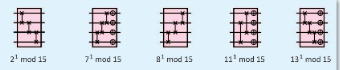



In [ ]:
#write code here
def xmod15_block(qc,qr,cr,a):
    if a == 2:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
    elif a == 7:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 8:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
    elif a == 11: # this is included for completeness
        qc.cswap(qr[4],qr[2],qr[0])
        qc.cswap(qr[4],qr[3],qr[1])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 13:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    return qc

Before we implement the algorithm for the x values mentioned in the above problem (2,7, etc.), there exists an optimized version for x = 11. Create a function (circuit_11mod15(qc, qr, cr)) that takes in the quantum circuit (qc), quantum register (qr), and classical register (cr) and outputs the circuit in the picture.

Important notes: Don't overlook the fact that q0 is 1! Think about how to initialize it to that state. The top qubit is q4 in your circuit. The blank squares in the picture are essentially doing nothing to the bottom qubits, so do not worry about them. The three measurements, from left to right, correspond to the first three classical bits (c0, c1, c2) respectively. The squares showing [90] and [45] with an arrow on top of them are controlled U1/Phase gates. For example, qc.u1(math.pi/2.,qr[4]).c_if(cr, 1) applies the "90" gate on q4 (top qubit) if the classical register has a value (00001). The |0> in the middle of the circuit means reseting the qubit (qc.reset(qubit)) to the |0> state. Finally, don't forget that every operation in a square on the bottom four qubits is controlled by the top qubit.


This optimized version is shown in the picture below: \\
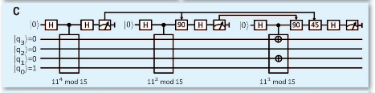

In [ ]:
#write code here
def circuit_11mod15(qc,qr,cr):
    # Initialize q[0] to |1>
    qc.x(qr[0])

    # Apply a**4 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[0])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    #   feed forward
    qc.p(math.pi/2.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[1])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply 11 mod 15
    qc.h(qr[4])
    #   controlled unitary.
    qc.cx(qr[4],qr[3])
    qc.cx(qr[4],qr[1])
    #   feed forward
    qc.p(3.*math.pi/4.,qr[4]).c_if(cr, 3)
    qc.p(math.pi/2.,qr[4]).c_if(cr, 2)
    qc.p(math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[2])
    return qc

qr = QuantumRegister(5)
cr = ClassicalRegister(5)
sub_circ = circuit_11mod15(QuantumCircuit(qr,cr), qr, cr)
sub_circ.draw()

┌───┐                                                                   »
q11_0: ┤ X ├───────────────────────────────────────────────────────────────────»
       └───┘                                                   ┌───┐           »
q11_1: ────────────────────────────────────────────────────────┤ X ├───────────»
                                                               └─┬─┘           »
q11_2: ──────────────────────────────────────────────────────────┼─────────────»
                                                          ┌───┐  │             »
q11_3: ───────────────────────────────────────────────────┤ X ├──┼─────────────»
       ┌───┐┌───┐┌─┐     ┌───┐┌────────┐┌───┐┌─┐     ┌───┐└─┬─┘  │  ┌─────────┐»
q11_4: ┤ H ├┤ H ├┤M├─|0>─┤ H ├┤ P(π/2) ├┤ H ├┤M├─|0>─┤ H ├──■────■──┤ P(3π/4) ├»
       └───┘└───┘└╥┘     └───┘└───╥────┘└───┘└╥┘     └───┘          └────╥────┘»
                  ║            ┌──╨──┐        ║                       ┌──╨──┐  »
 c8: 5/═══════════╩════════════╡ 0x1 ╞════════╩═══════════════════════╡ 0x3 ╞══»
                  0            └─────┘        1                       └─────┘  »
«                                   
«q11_0: ────────────────────────────
«                                   
«q11_1: ────────────────────────────
«                                   
«q11_2: ────────────────────────────
«                                   
«q11_3: ────────────────────────────
«       ┌────────┐┌────────┐┌───┐┌─┐
«q11_4: ┤ P(π/2) ├┤ P(π/4) ├┤ H ├┤M├
«       └───╥────┘└───╥────┘└───┘└╥┘
«        ┌──╨──┐   ┌──╨──┐        ║ 
« c8: 5/═╡ 0x2 ╞═══╡ 0x1 ╞════════╩═
«        └─────┘   └─────┘        2

Finally, create a function (circuit_xmod15(qc, qr, cr, x)) that takes in the quantum circuit (qc), quantum register (qr), and classical register (cr) and (x) and outputs the circuit in the picture. Your circuit should use the prior two functions you just made (the x=11 optimization, and the x-dependent red box operations). In the picture, the red box should be replaced with one of the red box operations you implemented depending on x.

Important Notes: This should be very similar to the x=11 circuit, and thus, relatively easy to implement.

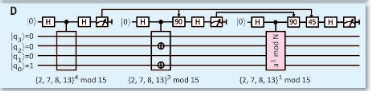



In [ ]:
#write code here
# qc = quantum circuit, qr = quantum register, cr = classical register, a = 2, 7, 8, 11 or 13
def circuit_xmod15(qc,qr,cr,a):
    if a == 11: return circuit_11mod15(qc,qr,cr)

    # Initialize q[0] to |1>
    qc.x(qr[0])

    # Apply a**4 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[0])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   controlled unitary
    qc.cx(qr[4],qr[2])
    qc.cx(qr[4],qr[0])
    #   feed forward
    qc.p(math.pi/2.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[1])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a mod 15
    qc.h(qr[4])
    #   controlled unitary.
    qc = xmod15_block(qc,qr,cr,a)
    #   feed forward
    qc.p(3.*math.pi/4.,qr[4]).c_if(cr, 3)
    qc.p(math.pi/2.,qr[4]).c_if(cr, 2)
    qc.p(math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[2])
    return qc

Test your circuit here for x = 7! We've written out the code for you. You should see several binary numbers with different probabilities. Print out a list of the numbers in decimal form.

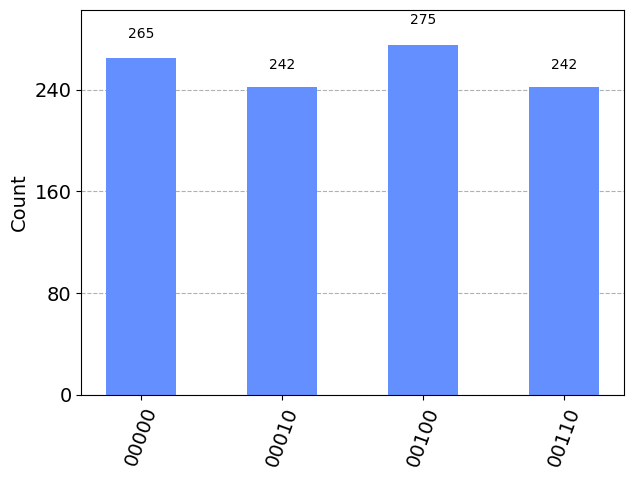

In [ ]:
qr = QuantumRegister(5, 'q')
cr = ClassicalRegister(5, 'c')

shor_init = QuantumCircuit(qr, cr)
shor = circuit_xmod15(shor_init,qr,cr,7)
shor.draw()

backend = BasicAer.get_backend('qasm_simulator')
sim_job = execute([shor], backend)
sim_result = sim_job.result()
sim_data = sim_result.get_counts(shor)
plot_histogram(sim_data)

#write code here

To find the period r, we need to first use something called **continued fraction approximation** on all of the results. This can essentially be done by taking the greatest common denominator of 2^3 and the result, and then dividing 2^3 by the calculated greatest common denominator. Print the results that give the expected period of 4.

In [ ]:
#write code here
def cfa(res, n):
  gcd = GCD(2**n, res)
  return (2**n) / gcd
print(cfa(2,3)) # second result
print(cfa(6,3)) # fourth result

4.0
4.0


Find which results give the expected period of 4 for x = 2 and x = 13.

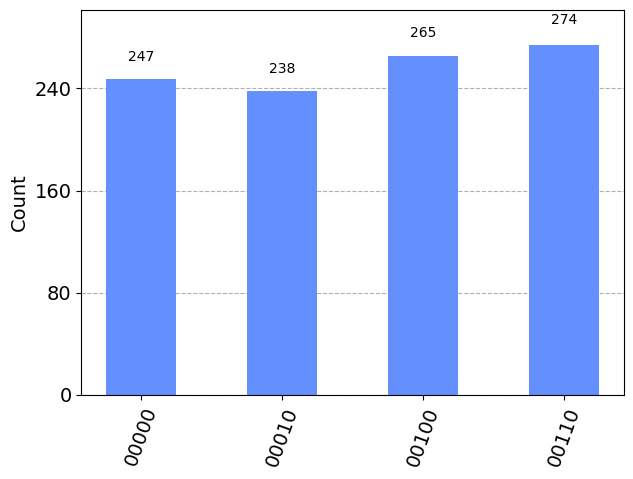

In [ ]:
#write code here
qr = QuantumRegister(5, 'q')
cr = ClassicalRegister(5, 'c')

shor_init = QuantumCircuit(qr, cr)
shor = circuit_xmod15(shor_init,qr,cr,2)
shor.draw()

backend = BasicAer.get_backend('qasm_simulator')
sim_job = execute([shor], backend)
sim_result = sim_job.result()
sim_data = sim_result.get_counts(shor)
plot_histogram(sim_data)


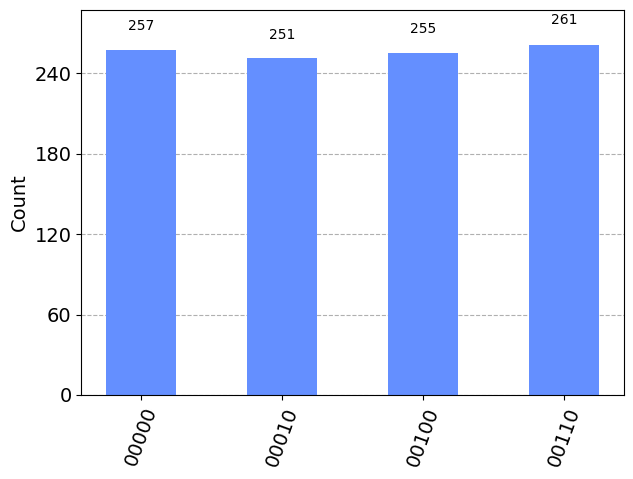

In [ ]:
qr = QuantumRegister(5, 'q')
cr = ClassicalRegister(5, 'c')

shor_init = QuantumCircuit(qr, cr)
shor = circuit_xmod15(shor_init,qr,cr,13)
shor.draw()

backend = BasicAer.get_backend('qasm_simulator')
sim_job = execute([shor], backend)
sim_result = sim_job.result()
sim_data = sim_result.get_counts(shor)
plot_histogram(sim_data)

Because the results are the same for x = 2 and x = 13, this answer is the same as the last (00010 and 00110)

For x = 7, use your function in the classical implementation portion to find factors p and q for N = 15.

In [ ]:
#write code here
print(find_factors(7, 15, 4))
# ^ relatively straightforward, but demonstrates that factors can be found once
# the period has been found.

(5, 3)


#Breaking RSA (5 points)

Using your RSA functions from the beginning, show how your knowledge of p and q would allow you to decrypt an encrypted message.

In [ ]:
#write code here

# using 11,17 example from the beginning

# parts of public key: N, e
N, e = public_key(11,17)
# parts of private key: d, n
# if p and q are known, d, n can be calculated by a hacker
d, N = private_key(11,17)
# encrypting message
m = "72"
encrypted_m = encrypt("72", N, e)
# decrypting message with d and n
decrypted_m = decrypt(encrypted_m, d, N)

print(decrypted_m)

72


#Extra Credit (5 points)

Read about Quantum Key Distribution (https://www.qmunity.tech/tutorials/quantum-key-distribution-with-bb84, https://en.wikipedia.org/wiki/Quantum_key_distribution). Explain why (or why not) this protocol might alleviate issues regarding Shor's Algorithm being able to crack RSA (in the case of enough Qubits/performance capability).

Answer should mention that QKD does not rely on the difficulty of finding factors for large numbers, which RSA is based on. If we changed from RSA to a system that utilized QKD, then Shor's Algorithm would not be able to crack it. Credit can also be given for suggestions and ways to incorporate QKD into RSA (sharing keys with the use of QKD).